# Simple Monte-Carlo Greeks by AD

This notebook compares the Greeks as calculated by Finite Difference versus Algorithmic Differentiation (AD) on Monte-Carlo simulated call options under Black-Scholes model.

AD is implemented with TensorFlow. We use nested AD to calculate 2nd order Greeks. A payoff smoother allows us to obtain the Gamma.

A final section compares these 2 methods against the Black-Scholes closed-form in a ladder test to show accuracy vs runtime and stability.

In [ ]:
# Import relevant modules
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import time as tm
import scipy.stats

print("TensorFlow version: " + tf.__version__)
print("NumPy version: " + np.__version__)
print("TensorFlow-Probability version: " + tfp.__version__)
print("SciPy version: " + scipy.__version__)

TensorFlow version: 2.9.2
NumPy version: 1.21.6
TensorFlow-Probability version: 0.17.0
SciPy version: 1.7.3


In [ ]:
# Parameters
expiry = 2
spot = 100.0
vol = 0.20
rate = 0.04
div = 0.01
strike = 100.0

# Bumps for differentials
spot_bump = 0.01  # Percentage of spot
vol_bump = 0.01  # Percentage of vol
time_bump = 1.0 / 365.0
rate_bump = 1.0 / 10000.0  # In bps

# Scalings
vega_scaling = 0.01  # Vega shown for 1% absolute moves
theta_scaling = 1.0 / 365.0  # Theta shown for 1d moves
rate_scaling = 1.0 / 10000.0  # DV01 shown for 1bp moves

# Random generator seed
seed = 42

# Runtime config
use_smoother_in_bumps = False

We implement a basic smoother for the $Max(x, 0)$ function. It is inspired from the Black-Scholes formula, the idea being to use Black-Scholes with small time/small vol to transform the max function into a smoother version of it.

Originally we used Black-Scholes directly, but we found that it introduces a visible bias on the price, presumably because Black-Scholes being always higher than the max, it introduces a consistently overestimating bias. Playing a little with similar functions we found another function that has a very similar shape but goes slightly in the negative domain and experimentally seems to have a lower bias on PV. That other function consists in using the $\mathcal{N}(d1)$ and $\mathcal{N}(d2)$ components but with slightly different weights on the spot vs the strike.

The second round of improvement is purely for performance. We observe a very big loss of speed performance when using such Black-Scholes-inspired smoother, presumably due to using the normal CDF. So we looked for functions with very similar properties but much easier to calculate.

Here inspiration comes from well-known activation functions on neural networks, where max is more commonly known as 'ReLU'. More specifically we use the parameterized sigmoid

\begin{equation}
Sig_\tau(x) = \frac{1}{1+\exp(-x/\tau)}
\end{equation} and we pick the value $\tau = 0.5879$ obtained as an optimum to match the actual normal CDF over the range $(-7, 7)$. We then use $Sig_{0.5879}()$ as a replacement for the normal CDF in our Black-Scholes inspired smoother.

In [ ]:
# Helper methods
def print_val(values, is_pv_vector=False):
    if is_pv_vector:
        print("PV: {:,.4f}".format(values[0][0]))
    else:
        print("PV: {:,.4f}".format(values[0]))
    print("Delta: {:,.4f}".format(values[1]))
    print("Gamma: {:,.4f}".format(values[2]))
    print("Vega: {:,.4f}".format(values[3]))
    print("Theta: {:,.4f}".format(values[4]))
    print("DV01: {:,.4f}".format(values[5]))
    print("Volga: {:,.4f}".format(values[6]))
    print("Vanna: {:,.4f}".format(values[7]))

# Smoothing parameters (for the max function)
smooth_vol = 0.40
smooth_time = 10.0 / 365.0
smooth_stdev = smooth_vol * np.sqrt(smooth_time)

# Tensorflow implementation of the payoff smoother ('tf_smooth_max')
tf_N = tfp.distributions.Normal(0.0, 1.0)

def tf_approx_cdf(x):
    return 1.0 / (1.0 + tf.math.exp(-x / 0.5879))

def tf_smooth_max(future_spot, strike):
    d1 = tf.math.log(future_spot / strike) / smooth_stdev + 0.5 * smooth_stdev
    d2 = d1 - smooth_stdev
    N1 = tf_approx_cdf(d1)
    N2 = tf_approx_cdf(d2)
    # N1 = tf_N.cdf(d1)
    # N2 = tf_N.cdf(d2)
    return future_spot * N1 - 0.5 * strike * (N1 + N2)  # Average
    # return future_spot * tf_N.cdf(d1) - strike * tf_N.cdf(d2)  # BS, overestimates
    # return (future_spot - strike) * tf_N.cdf(d1)  # Underestimates

# Numpy implementation of the payoof smoother ('smooth_max')
N = scipy.stats.norm

def approx_cdf(x):
    return 1.0 / (1.0 + np.exp(-x / 0.5879))

def smooth_max(future_spot, strike):
    d1 = np.log(future_spot / strike) / smooth_stdev + 0.5 * smooth_stdev
    d2 = d1 - smooth_stdev
    N1 = approx_cdf(d1)
    N2 = approx_cdf(d2)
    # N1 = N.cdf(d1)
    # N2 = N.cdf(d2)
    return future_spot * N1 - 0.5 * strike * (N1 + N2)  # Average
    # return future_spot * N.cdf(d1) - strike * N.cdf(d2)  # BS, overestimates
    # return (future_spot - strike) * N.cdf(d1)  # Underestimates

### 1) Standard Monte-Carlo
We implement a standard Monte-Carlo simulation with no AAD. First a function that calculates the PV by simulation, and then a bump calculator.

In [ ]:
# Standard simulator
def simulate_std(spot_, vol_, time_, rate_, gaussians):
    # Calculate deterministic forward
    fwd = spot_ * np.exp((rate_ - div) * time_)

    # Calculate final spot paths
    stdev = vol_ * np.sqrt(time_)
    future_spot = fwd * np.exp(-0.5 * stdev * stdev + stdev * gaussians)
    
    # Calculate discounted payoff
    df = np.exp(-rate_ * time_)
    if use_smoother_in_bumps:
        payoff = df * smooth_max(future_spot, strike)  # Use smoothing
    else:
        payoff = df * np.maximum(future_spot - strike, 0)
    
    # Reduce
    pv = np.mean(payoff, axis=0)
    
    return pv

In [ ]:
# Calculation by bumps
def calculate_bumps(spot_, vol_, time_, rate_, num_mc):
    rng = np.random.RandomState(seed)
    gaussians = rng.normal(0.0, 1.0, (num_mc, 1))

    pv = simulate_std(spot_, vol_, expiry, rate_, gaussians)

    # Delta-Gamma
    spot_u = spot_ * (1.0 + spot_bump)
    pv_spot_up = simulate_std(spot_u, vol_, time_, rate_, gaussians)

    spot_d = spot_ * (1.0 - spot_bump)
    pv_spot_down = simulate_std(spot_d, vol_, time_, rate_, gaussians)

    # Vega-Volga
    vol_u = vol_ * (1.0 + vol_bump)
    pv_vol_up = simulate_std(spot_, vol_u, time_, rate_, gaussians)

    vol_d = vol_ * (1.0 - vol_bump)
    pv_vol_down = simulate_std(spot_, vol_d, time_, rate_, gaussians)

    # Theta
    pv_expiry_down = simulate_std(spot_, vol_, time_ - time_bump, rate_, gaussians)

    # DV01
    pv_rate_up = simulate_std(spot_, vol_, time_, rate_ + rate_bump, gaussians)
    pv_rate_down = simulate_std(spot_, vol_, time_, rate_ - rate_bump, gaussians)

    # Vanna
    pv_uu = simulate_std(spot_u, vol_u, time_, rate_, gaussians)
    pv_ud = simulate_std(spot_u, vol_d, time_, rate_, gaussians)
    pv_du = simulate_std(spot_d, vol_u, time_, rate_, gaussians)
    pv_dd = simulate_std(spot_d, vol_d, time_, rate_, gaussians)

    # FDM
    delta = (pv_spot_up - pv_spot_down) / (2.0 * spot_bump * spot_)
    gamma = (pv_spot_up + pv_spot_down - 2.0 * pv) / np.power(spot_bump * spot_, 2)
    vega = (pv_vol_up - pv_vol_down) / (2.0 * vol_bump * vol_) * vega_scaling 
    theta = (pv_expiry_down - pv) / time_bump * theta_scaling
    dv01 = (pv_rate_up - pv_rate_down) / (2.0 * rate_bump) * rate_scaling
    volga = (pv_vol_up + pv_vol_down - 2.0 * pv) / np.power(vol_bump * vol_, 2) * np.power(vega_scaling, 2)
    vanna = (pv_uu - pv_ud - pv_du + pv_dd) / (4.0 * spot_bump * spot_ * vol_bump * vol_) * vega_scaling
          
    return [pv, delta, gamma, vega, theta, dv01, volga, vanna]

In [ ]:
# Test bumps
num_mc = 100 * 1000
values = calculate_bumps(spot, vol, expiry, rate, num_mc)

print_val([v[0] for v in values])

PV: 13.8276
Delta: 0.6264
Gamma: 0.0131
Vega: 0.5211
Theta: -0.0108
DV01: 0.0098
Volga: 0.0008
Vanna: -0.0013


### 2) AD Monte-Carlo
We implement PV and Greeks using AD. As the call payoff $Max(S - K, 0)$, function of $S$, is linear on both sides of the kink, directly using AD produces $\Gamma = 0$. The payoff smoother is inspired by (but only loosely connected to) the Black-Scholes formula. 

In [ ]:
# AAD 2nd order simulator with smoothing
def calculate_aad(spot_, vol_, time_, rate_, num_mc):
    rng = np.random.RandomState(seed)
    gaussians = rng.normal(0.0, 1.0, (num_mc, 1))

    tf_spot = tf.convert_to_tensor(spot_, dtype='float32')
    tf_vol = tf.convert_to_tensor(vol_)
    tf_time = tf.convert_to_tensor(time_, dtype='float32')
    tf_rate = tf.convert_to_tensor(rate_, dtype='float32')
    tf_div = tf.constant(div)
  
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([tf_spot, tf_vol, tf_time, tf_rate])
        with tf.GradientTape(persistent=True) as tape2nd:
            tape2nd.watch([tf_spot, tf_vol])

            # Calculate deterministic forward
            fwd = tf_spot * tf.math.exp((tf_rate - tf_div) * tf_time)

            # Calculate final spot paths
            stdev = tf_vol * tf.math.sqrt(tf_time)
            future_spot = fwd * tf.math.exp(-0.5 * stdev * stdev + stdev * gaussians)

            # Calculate discounted payoff
            df = tf.math.exp(-tf_rate * tf_time)
            payoff = df * tf_smooth_max(future_spot, strike)

            # Reduce
            pv = tf.reduce_mean(payoff, axis=0)

        # Calculate delta and vega
        g_delta = tape2nd.gradient(pv, tf_spot)
        g_vega = tape2nd.gradient(pv, tf_vol)
       
    delta = tape.gradient(pv, tf_spot)
    gamma = tape.gradient(g_delta, tf_spot)
    vega = tape.gradient(pv, tf_vol)
    theta = tape.gradient(pv, tf_time)
    dv01 = tape.gradient(pv, tf_rate)
    volga = tape.gradient(g_vega, tf_vol)
    vanna = tape.gradient(g_delta, tf_vol)
    
    # Scale
    vega = vega.numpy() * vega_scaling
    theta = -theta.numpy() * theta_scaling
    dv01 = dv01.numpy() * rate_scaling
    volga = volga.numpy() * np.power(vega_scaling, 2)
    vanna = vanna.numpy() * vega_scaling

    return [pv.numpy(), delta.numpy(), gamma.numpy(), vega, theta, dv01, volga, vanna]

In [ ]:
# Test AAD with smoothing
num_mc = 100 * 1000
values = calculate_aad(spot, vol, expiry, rate, num_mc)

print_val(values, is_pv_vector=True)

PV: 13.7992
Delta: 0.6262
Gamma: 0.0130
Vega: 0.5216
Theta: -0.0108
DV01: 0.0098
Volga: 0.0007
Vanna: -0.0013


### 3) AD Closed-Form (AD-CF)
Black-Scholes closed-forms calculated by AD for convenience.

In [ ]:
# Calculation by closed-form
def black_scholes(spot_, vol_, time_, rate_):
    tf_spot = tf.convert_to_tensor(spot_, dtype='float32')
    tf_vol = tf.convert_to_tensor(vol_)
    tf_time = tf.convert_to_tensor(time_, dtype='float32')
    tf_rate = tf.convert_to_tensor(rate_, dtype='float32')
    tf_div = tf.constant(div)
  
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([tf_spot, tf_vol, tf_time, tf_rate])
        with tf.GradientTape(persistent=True) as tape2nd:
            tape2nd.watch([tf_spot, tf_vol])

            fwd = tf_spot * tf.math.exp((tf_rate - tf_div) * tf_time)
            stdev = tf_vol * tf.math.sqrt(tf_time)
            d1 = tf.math.log(fwd / strike) / stdev + 0.5 * stdev
            d2 = d1 - stdev
            df = tf.math.exp(-tf_rate * tf_time)
            pv = df * (fwd * tf_N.cdf(d1) - strike * tf_N.cdf(d2))

        # Calculate delta and vega
        g_delta = tape2nd.gradient(pv, tf_spot)
        g_vega = tape2nd.gradient(pv, tf_vol)
       
    delta = tape.gradient(pv, tf_spot)
    gamma = tape.gradient(g_delta, tf_spot)
    vega = tape.gradient(pv, tf_vol)
    theta = tape.gradient(pv, tf_time)
    dv01 = tape.gradient(pv, tf_rate)
    volga = tape.gradient(g_vega, tf_vol)
    vanna = tape.gradient(g_delta, tf_vol)
    
    # Scale
    vega = vega.numpy() * vega_scaling
    theta = -theta.numpy() * theta_scaling
    dv01 = dv01.numpy() * rate_scaling
    volga = volga.numpy() * np.power(vega_scaling, 2)
    vanna = vanna.numpy() * vega_scaling

    return [pv.numpy(), delta.numpy(), gamma.numpy(), vega, theta, dv01, volga, vanna]


In [ ]:
# Calculate with closed-form
values = black_scholes(spot, vol, expiry, rate)

print_val(values)

PV: 13.7950
Delta: 0.6255
Gamma: 0.0130
Vega: 0.5195
Theta: -0.0107
DV01: 0.0098
Volga: 0.0006
Vanna: -0.0013


### 4) Numerical Testing
We generate a ladder of spot values to draw charts comparing the bump method with AD. This also allows us to compare speed and tune the smoothing parameter within the trade-off between smoothness of the Greeks and bias on PV.

We find that the smoothing is quite costly for runtime, although as explained earlier using approximated versions of it lead to a good performance improvement with no visible loss of accuracy. We also find that it is mostly the smoothing that improves the smoothness of the Greeks, as can be seen by enabling it (commenting it in) in the bump method.

To summarize: in order to obtain 2nd order Greeks with AD in TensorFlow we are forced to introduce a payoff smoother as otherwise the result is 0 (presumably because the 2nd differential is 0 on both sides of the strike). Unfortunately, the calculation of the smoother itself, at least in the sample payoff used in this work, represents a significant portion of the runtime.

While for AD we have no other choice here (if we want our 2nd order Greeks by AD), for the bump method we are not forced to use a smoother. We find that using a smoother gives a major improvement on the 2nd order Greeks, but again comes at a significant runtime cost.

Experimentally in the below we find that when both bumps and AD use the smoother, their results are highly similar in accuracy and smoothness. At lower numbers of simulations, the bump method is faster, but speeds equalize around 15k simulations. At 100k simulations, AD is 2x faster.

When the bump method does not use the smoother, it consistently wins against AD in speed, but its 2nd order Greeks show bad instabilities, which can be mildened only at the cost of running a very large number of simulations.

In [ ]:
# Ladder tests
num_points = 100  # Number of loops/points in the charts
min_s = 20.0
max_s = 200.0
spots = np.linspace(min_s, max_s, num_points, dtype='double')  # spot ladder
print("Displaying {c:,} points over spot range [{a:,}, {b:,}]".format(c=num_points, a=min_s, b=max_s))

# Vectorize for broadcasting
vols = np.ones(num_points, dtype='float32') * vol
times = np.ones(num_points, dtype='float32') * expiry
rates = np.ones(num_points, dtype='float32') * rate

# Bump method
print("Calculating with bumps...")
num_mc = 20 * 1000  # Number of simulations
print("Number of simulations: {:,}".format(num_mc))
time_bmp = tm.time()
results_bmp = calculate_bumps(spots, vols, times, rates, num_mc)
time_bmp = tm.time() - time_bmp

# AAD
print("Calculating with AAD...")
num_mc = 20 * 1000  # Number of simulations
print("Number of simulations: {:,}".format(num_mc))
time_aad = tm.time()
results_aad = calculate_aad(spots, vols, times, rates, num_mc)
time_aad = tm.time() - time_aad

# AD closed-form
print("Calculating with AD closed-form...")
time_adcf = tm.time()
results_adcf = black_scholes(spots, vols, times, rates)
time_adcf = tm.time() - time_adcf

print("Calculation complete!")
print('Runtime(Bumps): %.1f' % time_bmp + 's')
print('Runtime(AAD): %.1f' % time_aad + 's')
print('Runtime(AD-CF): %.1f' % time_adcf + 's')

Displaying 100 points over spot range [20.0, 200.0]
Calculating with bumps...
Number of simulations: 20,000
Calculating with AAD...
Number of simulations: 20,000
Calculating with AD closed-form...
Calculation complete!
Runtime(Bumps): 1.5s
Runtime(AAD): 3.0s
Runtime(AD-CF): 0.2s


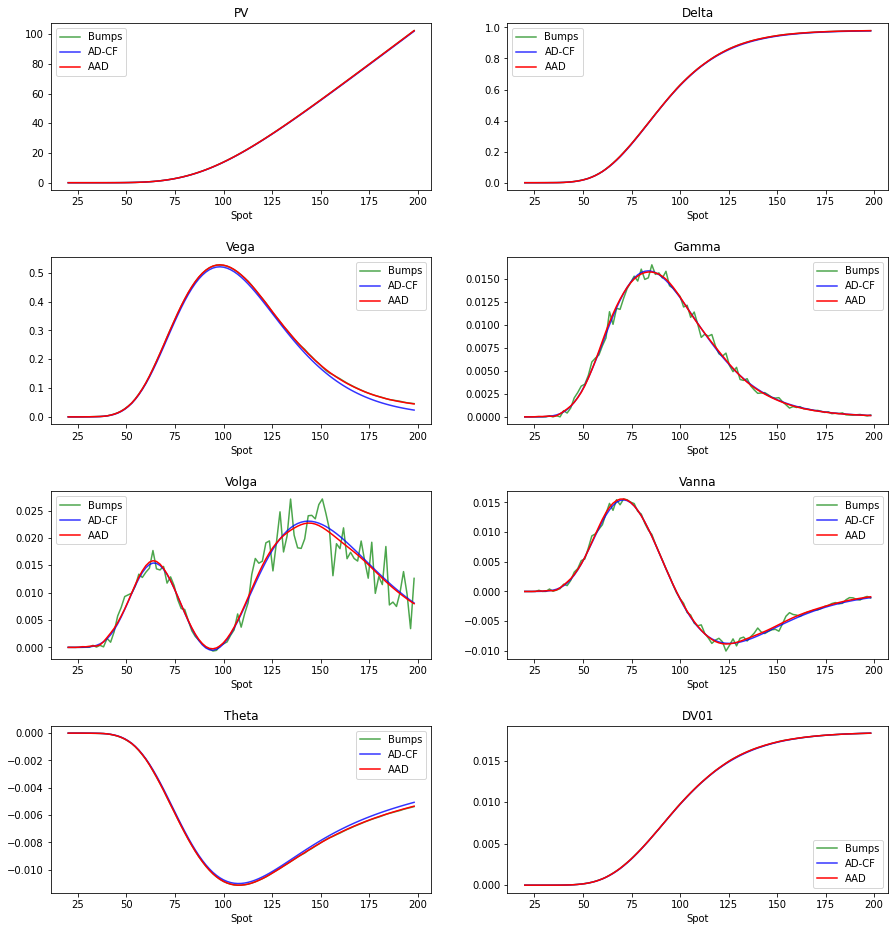

In [ ]:
results_bmp = np.array(results_bmp)
results_aad = np.array(results_aad)
results_adcf = np.array(results_adcf)

# Select viewing range
view_min = min_s  # Choose larger to zoom in
view_max = max_s  # Choose smaller to zoom in

view_range = [i for i in range(num_points) if spots[i] >= view_min and spots[i] <= view_max]
start = view_range[0]
end = view_range[-1]

def plot_value(plt_idx, name, result_idx, legend_location):
    plt.subplot(4, 2, plt_idx)
    plt.title(name)
    plt.xlabel('Spot')
    plt.plot(spots[start:end], results_bmp[result_idx][start:end], 'green', alpha=0.7, label='Bumps')
    plt.plot(spots[start:end], results_adcf[result_idx][start:end], color='blue', alpha=0.8, label='AD-CF')
    plt.plot(spots[start:end], results_aad[result_idx][start:end], color='red', label='AAD')
    plt.legend(loc=legend_location)

# Plot results
plt.ioff()
plt.figure(figsize=(15, 16))
plt.subplots_adjust(hspace=0.40, wspace=0.20)

plot_value(1, "PV", 0, 'upper left')
plot_value(2, "Delta", 1, 'upper left')
plot_value(3, "Vega", 3, 'upper right')
plot_value(4, "Gamma", 2, 'upper right')
plot_value(5, "Volga", 6, 'upper left')
plot_value(6, "Vanna", 7, 'upper right')
plot_value(7, "Theta", 4, 'upper right')
plot_value(8, "DV01", 5, 'lower right')

plt.show()